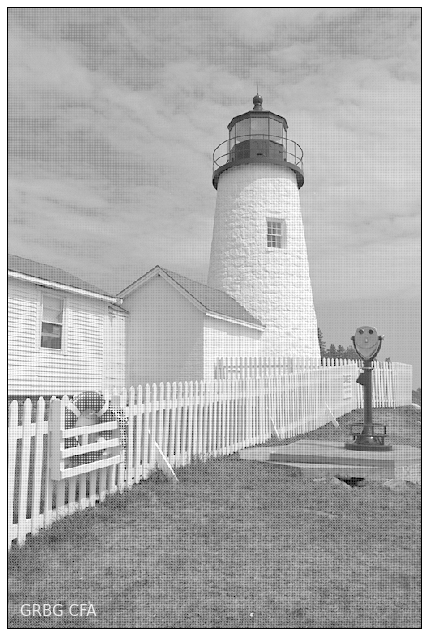

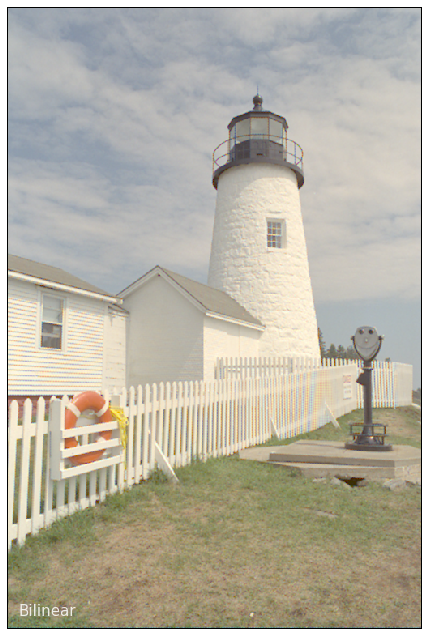

/Users/kelsolaar/Documents/Development/Environments/colour-hdri/lib/python2.7/site-packages/colour/models/dataset/srgb.py:111: RuntimeWarning: invalid value encountered in power
  1.055 * (value ** (1 / 2.4)) - 0.055)


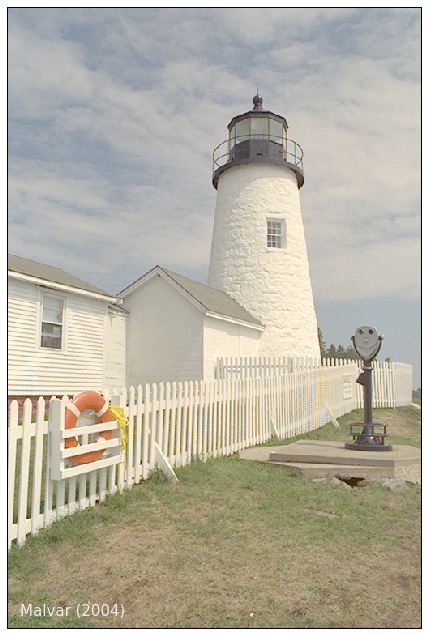

True

In [1]:
%matplotlib inline

from __future__ import division

import numpy as np

import colour
from colour.plotting import *

from colour_hdri.cfa.bayer.demosaicing.bilinear import demosaicing_CFA_Bayer_bilinear
from colour_hdri.cfa.bayer.demosaicing.malvar2004 import demosaicing_CFA_Bayer_Malvar2004
from colour_hdri.cfa.bayer.mosaicing import mosaicing_CFA_Bayer

DIRECTORY = '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/resources/CFA/'

OECF = colour.RGB_COLOURSPACES['sRGB'].transfer_function

IMAGE = np.squeeze(colour.read_image(DIRECTORY + 'lighthouse.tif'))

CFA = mosaicing_CFA_Bayer(IMAGE, 'GRBG')

colour.write_image(colour.tstack((CFA, CFA, CFA)), DIRECTORY + 'lighthouse_CFA.tif')

image_plot(OECF(colour.tstack((CFA, CFA, CFA))), 'GRBG CFA')

image_plot(OECF(demosaicing_CFA_Bayer_bilinear(CFA, 'GRBG')), 'Bilinear')    
image_plot(OECF(demosaicing_CFA_Bayer_Malvar2004(CFA, 'GRBG')), 'Malvar (2004)') 

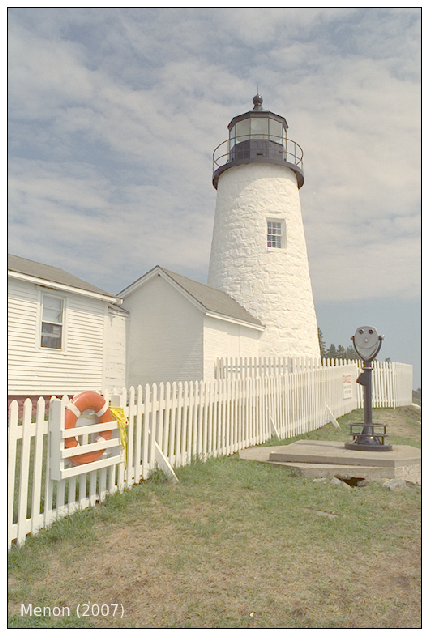

True

In [2]:
from __future__ import division

import numpy as np
from scipy.ndimage.filters import convolve, convolve1d

from colour import tstack

from colour_hdri.cfa.bayer.masks import masks_CFA_Bayer


def demosaicing_CFA_Bayer_Menon2007(CFA, pattern='grbg'):
    CFA = np.asarray(CFA)
    R_m, G_m, B_m = masks_CFA_Bayer(CFA.shape, pattern)

    h_0 = np.array([0, 0.5, 0, 0.5, 0])
    h_1 = np.array([-0.25, 0, 0.5, 0, -0.25])

    R = CFA * R_m
    G = CFA * G_m
    B = CFA * B_m

    cnv_h = lambda x, y: convolve1d(x, y, mode='mirror')
    cnv_v = lambda x, y: convolve1d(x, y, mode='mirror', axis=0)

    G_H = np.where(G == 0, cnv_h(CFA, h_0) + cnv_h(CFA, h_1), G)
    G_V = np.where(G == 0, cnv_v(CFA, h_0) + cnv_v(CFA, h_1), G)

    C_H = np.where(R_m == 1, R - G_H, 0)
    C_H = np.where(B_m == 1, B - G_H, C_H)

    C_V = np.where(R_m == 1, R - G_V, 0)
    C_V = np.where(B_m == 1, B - G_V, C_V)

    D_H = np.abs(C_H - np.pad(C_H, ((0, 0), (0, 2)), mode='reflect')[:, 2:])
    D_V = np.abs(C_V - np.pad(C_V, ((0, 2), (0, 0)), mode='reflect')[2:, :])

    k = np.array(
        [[0, 0, 1, 0, 1],
         [0, 0, 0, 1, 0],
         [0, 0, 3, 0, 3],
         [0, 0, 0, 1, 0],
         [0, 0, 1, 0, 1]])

    d_H = convolve(D_H, k, mode='constant')
    d_V = convolve(D_V, np.transpose(k), mode='constant')

    mask = d_V >= d_H
    G = np.where(mask, G_H, G_V)
    M = np.where(mask, 1, 0)

    # Red rows.
    R_r = np.transpose(np.any(R_m == 1, axis=1)[np.newaxis]) * np.ones(R.shape)
    # Blue rows.
    B_r = np.transpose(np.any(B_m == 1, axis=1)[np.newaxis]) * np.ones(B.shape)

    k_b = np.array([0.5, 0, 0.5])

    R = np.where(np.logical_and(G_m == 1, R_r == 1),
                 G + cnv_h(R, k_b) - cnv_h(G, k_b),
                 R)

    R = np.where(np.logical_and(G_m == 1, B_r == 1) == 1,
                 G + cnv_v(R, k_b) - cnv_v(G, k_b),
                 R)

    B = np.where(np.logical_and(G_m == 1, B_r == 1),
                 G + cnv_h(B, k_b) - cnv_h(G, k_b),
                 B)

    B = np.where(np.logical_and(G_m == 1, R_r == 1) == 1,
                 G + cnv_v(B, k_b) - cnv_v(G, k_b),
                 B)

    R = np.where(np.logical_and(B_r == 1, B_m == 1),
                 np.where(M == 1,
                          B + cnv_h(R, k_b) - cnv_h(B, k_b),
                          B + cnv_v(R, k_b) - cnv_v(B, k_b)),
                 R)

    B = np.where(np.logical_and(R_r == 1, R_m == 1),
                 np.where(M == 1,
                          R + cnv_h(B, k_b) - cnv_h(R, k_b),
                          R + cnv_v(B, k_b) - cnv_v(R, k_b)),
                 B)

    colour.write_image(tstack((R, G, B)), DIRECTORY + 'Menon_RGB.tif')

    return tstack((R, G, B))


image_plot(OECF(demosaicing_CFA_Bayer_Menon2007(CFA)), 'Menon (2007)')
